In [ ]:
from IPython.display import clear_output

# Content

In this notebook we will finetune a transformer network taken from huggingface, using huggingface's Trainer API

we will train facebook's mbart model to create a two way chinese to urdu language translator.

The reason for chosing mbart as the source model is because it has already seen a lot of languages's data(50 in our case) during pre-training

you can find more information about mbart on [hugging face](https://huggingface.co/facebook/mbart-large-50)

In [ ]:
# %pip install gdown
# %pip install evaluate
# %pip install pandas
# %pip install sentencepiece
# %pip install accelerator
# %pip install protobuf==3.20.3
# %pip install matplotlib
# %pip install transformers datasets

# %pip install --disable-pip-version-check \
#     torch \
#     torchdata --quiet

# %pip install tqdm

clear_output()

In [22]:
%pip install datasets
%pip install transformers[torch]  # [torch] because Trainer API with torch needs accelerator installed. This takes care of that. Might need a restart of the session
%pip install gdown==4.5
%pip install evaluate
%pip install rouge_score

clear_output()

In [42]:
import math

import pandas as pd
import gdown

from datasets import load_dataset, Dataset
from transformers import GenerationConfig, TrainingArguments, Trainer, TrainerCallback
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch
import time
import pandas as pd
import evaluate
from tqdm import tqdm
import json

import matplotlib.pyplot as plt

import random

## Downloading the data

In [ ]:
!gdown 1ivqxeMVKDrHtjxBf3QXLAo7T9GciqNy-  # train.csv
!gdown 1Y0Ls3Rzr9MJr07fw91mFf2iSagl5CVt5  # test.csv

Downloading...
From: https://drive.google.com/uc?id=1ivqxeMVKDrHtjxBf3QXLAo7T9GciqNy-
To: /content/train.csv
100% 16.4M/16.4M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y0Ls3Rzr9MJr07fw91mFf2iSagl5CVt5
To: /content/test.csv
100% 1.82M/1.82M [00:00<00:00, 155MB/s]


In [ ]:
random.seed(7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = pd.read_csv('train.csv', usecols=['urdu', 'chinese'])
test_data = pd.read_csv('test.csv', usecols=['urdu', 'chinese'])

In [ ]:
train_data.head()

,urdu,chinese
0,اگرچہ وی چیٹ کے حکام کریک ڈاؤن جاری رکھتے ہیں،...,虽然微信官方不断打击，但要根治侵权‘清粉’软件恐怕并不容易。
1,کی علامات کا جلد از جلد علاج کرنے کے لیے، مریض...,为了尽快调理好内分泌失调的症状，患者需要保持好的心态。\nendocrine dyscrasia
2,زائرین کی طرف سے اکثر یہ پوچھا جاتا ہے کہ صرف ...,常有参观者问，为什么只能找到一万多个姓名？这也一直是史学研究者们的心结。
3,سترھویں سی پی سی مرکزی کمیٹی کے ساتویں مکمل اج...,这是党的十七届六中全会提出建设社会主义文化强国以来，党中央首次明确了建成文化强国的具体时间表。
4,سفر میں تبدیلی کا موقع بڑا ہے، اسی لئے چاہے آن...,旅行是未知的，所以是否买往返的联成票要注意。


In [ ]:
train_dataset = Dataset.from_pandas(train_data, split='train')
test_dataset = Dataset.from_pandas(test_data, split='test')

## Prepare the model and tokenizers

In [ ]:
model_name='facebook/mbart-large-50'

model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer1 = MBart50TokenizerFast.from_pretrained(model_name, src_lang="zh_CN", tgt_lang="ur_PK")
tokenizer2 = MBart50TokenizerFast.from_pretrained(model_name, src_lang="ur_PK", tgt_lang="zh_CN")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_function(rows):

    src_language = 'chinese'
    tgt_language = 'urdu'

    if random.randint(0, 1) == 1:
        src_language, tgt_language = tgt_language, src_language

    src_tokenizer, tgt_tokenizer = [get_apt_tokenizer(language) for language in (src_language, tgt_language)]

    start_prompt = f''
    end_prompt = f''
    prompt = [start_prompt + row + end_prompt for row in rows[src_language]]
    rows['src_language'] = [src_language]*len(rows[src_language])
    rows['prompt'] = prompt
    encoding = src_tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt", max_length=256)
    rows['input_ids'], rows['attention_mask'] = encoding.input_ids, encoding.attention_mask
    rows['labels'] = tgt_tokenizer(rows[tgt_language], padding="max_length", truncation=True, return_tensors="pt", max_length=256).input_ids

    return rows

def get_apt_tokenizer(src_language):
    if src_language.lower() == 'chinese':
        return tokenizer1
    elif src_language.lower() == 'urdu':
        return tokenizer2
    else:
        raise ValueError('Invalid Language')

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/27018 [00:00<?, ? examples/s]

Map:   0%|          | 0/3002 [00:00<?, ? examples/s]

## Check to see tokenizer is working correctly by encoding and decoding

In [ ]:
idx = 2501
row = tokenized_test_dataset[idx]
tokenizer = get_apt_tokenizer(row['src_language'])
# print(row)
print(f'{row["src_language"]=}')
print(row['chinese'])
print(row['urdu'])
print(tokenizer.decode(row['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(row['labels'], skip_special_tokens=True))

row["src_language"]='urdu'
积极发展多式联运，加快铁路、公路与港口、园区连接线建设。
فعال طور پر ملٹی موڈل ٹرانسپورٹ تیار کریں اور ریلوے ، سڑکوں اور بندرگاہوں اور پارکوں کے مابین کنکشن لائنوں کی تعمیر کو تیز کریں۔
فعال طور پر ملٹی موڈل ٹرانسپورٹ تیار کریں اور ریلوے ، سڑکوں اور بندرگاہوں اور پارکوں کے مابین کنکشن لائنوں کی تعمیر کو تیز کریں۔
积极发展多式联运,加快铁路、公路与港口、园区连接线建设。


In [ ]:
tokenized_train_dataset.shape

(27018, 7)

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.shuffle(seed=13)
tokenized_test_dataset = tokenized_test_dataset.shuffle(seed=13)

In [ ]:
print(tokenized_train_dataset.shape)
tokenized_train_dataset

(27018, 7)


Dataset({
    features: ['urdu', 'chinese', 'src_language', 'prompt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 27018
})

## Pre-trained model

In [ ]:
sample_chinese = '加强企业法治文化建设,提高经营管理人员依法经营、依法管理能力。'
with torch.no_grad():
    res = model.generate(**tokenizer1(sample_chinese, return_tensors='pt'))
tokenizer1.batch_decode(res)[0]

'</s><s> 加强企业法治文化建设,提高经营管理人员依法经营、依法管理能力。</s>'

## Training the model

In [ ]:
# Create a list to store losses
train_losses = []
val_losses = []

# Custom callback to store losses every 500 steps
class CustomCallback(TrainerCallback):

    def on_log(self, args, state, control, **kwargs):
        # Check if training loss is available in the logs
        if "train_loss" in state.log_history:
            train_loss = state.log_history["train_loss"]
            train_losses.append(train_loss)

        # Check if validation loss is available in the logs
        if "eval_loss" in state.log_history:
            val_loss = state.log_history["eval_loss"]
            val_losses.append(val_loss)

output_dir = f'./checkpoints/mbart-large-translator-full-run'  # full for full fine tune

training_args = TrainingArguments(
    output_dir=output_dir,
    # per_device_train_batch_size=4,
    auto_find_batch_size=True,
    learning_rate=5e-5,
    num_train_epochs=2,
    eval_steps=500,
    save_steps=5000,
    logging_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    # load_best_model_at_end=True,
    warmup_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    # compute_metrics=lambda x: 1
    callbacks=[CustomCallback()]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:
model.save_pretrained('mbart_2ep_full_finetuned_bidir')

In [ ]:
sample_chinese = '加强企业'
with torch.no_grad():
    encoding = tokenizer1(sample_chinese, return_tensors='pt')
    input_ids, attn_mask = encoding.input_ids.to(model.device), encoding.attention_mask.to(model.device)
    res = model.generate(input_ids=input_ids, attention_mask=attn_mask)
print(tokenizer1.batch_decode(res)[0])

</s>zh_CN کاروباری اداروں کو مضبوط بنانے کے لیے کاروباری اداروں کو تقویت دیں۔</s>


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
sample_urdu = 'اہمیں ابتدائی کارکردگی پر توجہ دینی چاہیے اور ان احتیاطی تدابیر پر عمل کرنا چاہیے تاکہ مسائل سے بچا جا سکے۔'
with torch.no_grad():
    encoding = tokenizer2(sample_urdu, return_tensors='pt')
    input_ids, attn_mask = encoding.input_ids.to(model.device), encoding.attention_mask.to(model.device)
    res = model.generate(input_ids=input_ids, attention_mask=attn_mask)
print(tokenizer2.batch_decode(res)[0])

</s>ur_PK 注意初期的性能,做好这些预防才能避免其中的问题。</s>


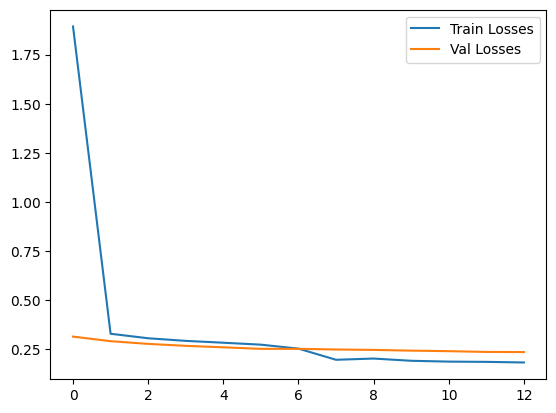

In [ ]:
plt.plot(train_losses, label='Train Losses')
plt.plot(val_losses, label='Val Losses')

plt.legend()
plt.show()

## Evaluating the results

In [33]:
untrained_model = MBartForConditionalGeneration.from_pretrained(model_name)

In [28]:
bleu = evaluate.load('bleu')

In [29]:
cn_to_ur_data = test_data.sample(frac=0.5, random_state=123)
ur_to_cn_data = test_data.loc[test_data.index.difference(cn_to_ur_data.index)]

In [36]:
batch_size = 16

num_batches = int(math.ceil(len(cn_to_ur_data)/batch_size))

all_untrained_model_outputs = []
all_trained_model_outputs = []

for i in tqdm(range(num_batches)):

    batch_start = i*batch_size
    batch_end = batch_start + batch_size

    batch_df = cn_to_ur_data.iloc[batch_start:] if i == num_batches - 1 else cn_to_ur_data.iloc[batch_start: batch_end]

    prompts = [f'{chinese}' for chinese in batch_df['chinese']]

    with torch.no_grad():

        encodings = tokenizer1(prompts, return_tensors="pt", padding="max_length", truncation=True, max_length=256)

        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)

        model_outputs = model.generate(input_ids=input_ids,
                                                         attention_mask=attention_mask,
                                                         generation_config=GenerationConfig(max_new_tokens=256))
        model_text_output = tokenizer1.batch_decode(model_outputs, skip_special_tokens=True)
        all_untrained_model_outputs.extend(model_text_output)

        trained_model_outputs = model.generate(input_ids=input_ids,
                                                 attention_mask=attention_mask,
                                                 generation_config=GenerationConfig(max_new_tokens=256))
        trained_model_text_output = tokenizer1.batch_decode(trained_model_outputs, skip_special_tokens=True)
        all_trained_model_outputs.extend(trained_model_text_output)

100%|██████████| 94/94 [05:41<00:00,  3.64s/it]


In [39]:
cn_to_ur_data['trained_model_urdu'] = all_trained_model_outputs
cn_to_ur_data['untrained_model_urdu'] = all_untrained_model_outputs

In [40]:
original_bleu = bleu.compute(
    predictions=cn_to_ur_data['untrained_model_urdu'],
    references=cn_to_ur_data['urdu'],
)

trained_bleu = bleu.compute(
    predictions=cn_to_ur_data['trained_model_urdu'],
    references=cn_to_ur_data['urdu'],
)

In [49]:
print('Chinese to Urdu')
print('Original model:')
print(json.dumps(original_bleu, indent=2))
print('Trained model:')
print(json.dumps(trained_bleu, indent=2))

Chinese to Urdu
Original model:
{
  "bleu": 3.544702770899656e-05,
  "precisions": [
    0.013787510137875101,
    0.002034933016788197,
    0.0015387997362057595,
    0.0006080875646093037
  ],
  "brevity_penalty": 0.015659712253059135,
  "length_ratio": 0.19392382500196598,
  "translation_length": 7398,
  "reference_length": 38149
}
Trained model:
{
  "bleu": 0.13825255571559253,
  "precisions": [
    0.42709875100620603,
    0.1869224533909754,
    0.09369455630966797,
    0.04884144907080687
  ],
  "brevity_penalty": 1.0,
  "length_ratio": 1.0094891084956354,
  "translation_length": 38511,
  "reference_length": 38149
}

